In [2]:
import xarray as xr
import os
import numpy as np
from datetime import datetime
from earth2studio.utils.type import TimeArray, VariableArray


class DataLocal:
    """
    A class for loading weather data at a specific timestamp.
    
    """
    
    # --- Define all configuration as class attributes ---
    # Fixed set of all variables
    VARIABLES = [
        "u10m", "v10m", "u100m", "v100m", "t2m", "sp", "msl", "tcwv",
        "u50", "u100", "u150", "u200", "u250", "u300", "u400", "u500", "u600", "u700", "u850", "u925", "u1000",
        "v50", "v100", "v150", "v200", "v250", "v300", "v400", "v500", "v600", "v700", "v850", "v925", "v1000",
        "z50", "z100", "z150", "z200", "z250", "z300", "z400", "z500", "z600", "z700", "z850", "z925", "z1000",
        "t50", "t100", "t150", "t200", "t250", "t300", "t400", "t500", "t600", "t700", "t850", "t925", "t1000",
        "q50", "q100", "q150", "q200", "q250", "q300", "q400", "q500", "q600", "q700", "q850", "q925", "q1000",
    ]
    # Timestamp to load
    SPECIFIC_TIME = "2020-07-21T18:00:00"

    SURFACE_VARIABLES_MAPPING = {
        "u10m": "10m_u_component_of_wind", "v10m": "10m_v_component_of_wind", "u100m": "100m_u_component_of_wind",
        "v100m": "100m_v_component_of_wind", "t2m": "2m_temperature", "sp": "surface_pressure",
        "msl": "mean_sea_level_pressure", "tcwv": "total_column_water_vapour",
    }
    UPPER_VARIABLES_MAPPING = {
        "u": "u_component_of_wind", "v": "v_component_of_wind", "z": "geopotential",
        "t": "temperature", "q": "specific_humidity",
    }
    PRESSURE_LEVELS = ["50", "100", "150", "200", "250", "300", "400", "500", "600", "700", "850", "925", "1000"]

    def __init__(self, base_path: str):
        """
        Initialize the data loader.
        Args:
            base_path (str): Root directory for the nc files.
        """
        self.base_path = base_path

    def _read_and_slice(self, file_path: str, specific_time: str) -> np.ndarray | None:
        """
        Read a single file and return the slice at the specific timestamp as a numpy array.
        """
        if not os.path.exists(file_path):
            print(f"Warning: File not found: {file_path}")
            return None

        with xr.open_dataset(file_path) as ds:
            for var_name, da in ds.data_vars.items():
                if len(da.shape) == 3 and "time" in da.dims:
                    specific_time_np64 = np.datetime64(specific_time)
                    if specific_time_np64 in da.time.values:
                        return da.sel(time=specific_time_np64).values
                    else:
                        print(f"Warning: Time '{specific_time}' not found in {file_path}. Skipping.")
                        return None
        print(f"Warning: No valid variables found in file {file_path}.")
        return None

    def __call__(
        self,
        _time: datetime | list[datetime] | TimeArray,
        _variable: str | list[str] | VariableArray,
    ) -> xr.DataArray:
        """
        Load and assemble data for the predefined timestamp and variable set.
        
        """
        all_data = []
        lat, lon = None, None

        for var in self.VARIABLES:
            data = None
            file_path = ""
            if var in self.SURFACE_VARIABLES_MAPPING:
                variable_name = self.SURFACE_VARIABLES_MAPPING[var]
                file_path = os.path.join(self.base_path, variable_name, "surface.nc")
                data = self._read_and_slice(file_path, self.SPECIFIC_TIME)
            else:
                for upper_var, upper_file_name in self.UPPER_VARIABLES_MAPPING.items():
                    if var.startswith(upper_var):
                        pressure_level = var[len(upper_var):]
                        if pressure_level in self.PRESSURE_LEVELS:
                            file_path = os.path.join(self.base_path, upper_file_name, f"{pressure_level}.nc")
                            data = self._read_and_slice(file_path, self.SPECIFIC_TIME)
                            break
            
            if data is not None:
                all_data.append(data)
                if lat is None or lon is None and os.path.exists(file_path):
                     with xr.open_dataset(file_path) as ds:
                        lat = ds["latitude"].values
                        lon = ds["longitude"].values
        
        if not all_data:
            raise ValueError(f"No data successfully loaded for timestamp {self.SPECIFIC_TIME}.")

        data_array = np.stack(all_data, axis=0)
        data_array = np.expand_dims(data_array, axis=0)

        final_data = xr.DataArray(
            data_array,
            dims=["time", "variable", "lat", "lon"],
            coords={
                "time": [np.datetime64(self.SPECIFIC_TIME)],
                "variable": self.VARIABLES,
                "lat": lat,
                "lon": lon,
            },
        )
        return final_data


# if __name__ == '__main__':

#     base_path = '.' 

#     loader = DataLocal(base_path=base_path)

#     print("DataLoader...")
#     try:
#         final_data = loader(_time=None, _variable=None)
        
#         print("\nSuccessfully assembled final_data:")
#         print(final_data)
#     except Exception as e:
#         print(f"\nExecution error: {e}")

In [4]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES.
# SPDX-FileCopyrightText: All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["EARTH2STUDIO_PACKAGE_TIMEOUT"] = "10000"
import subprocess as sp

os.makedirs("outputs", exist_ok=True)
output_file="./outputs/solar.nc"
from earth2studio.data import GFS, CDS, IFS
from earth2studio.io.netcdf4 import NetCDF4Backend
from earth2studio.models.auto import Package
from earth2studio.models.px import SFNO
from earth2studio.run import deterministic, diagnostic

from fcinterp.interp import ForecastInterpolation
from diagnostic.solarradiation_1h_afno import SolarRadiationAFNO
from collections import OrderedDict
from datetime import datetime
from math import ceil

import numpy as np
import torch
from tqdm import tqdm

from earth2studio.data import DataSource, fetch_data
from earth2studio.io import IOBackend
from earth2studio.models.dx import DiagnosticModel
from earth2studio.models.px import PrognosticModel
from earth2studio.perturbation import Perturbation
from earth2studio.utils.coords import CoordSystem, map_coords
from earth2studio.utils.time import to_time_array
from solarcorrdiff import scall_in_VARIABLES, SolarCorrdiffAll, scall_out_VARIABLES
import matplotlib.pyplot as plt
import copy
# Load the default model package which downloads the check point from NGC
forecast_package = SFNO.load_default_package()
forecast_model = SFNO.load_model(forecast_package)

# Load the interpolation model
interp_package_path = "./fcinterp"
prognostic_model = ForecastInterpolation.load_model(
        Package(interp_package_path, cache=False),
        fc_model=forecast_model,
)

# Load the diagnostic model for ssrd
diagnostic_package_path = "./diagnostic" 
diagnostic_model = SolarRadiationAFNO.load_model(
        Package(diagnostic_package_path, cache=False),
)


# Load the downscaling model for ssrd
solarcorrdiff_package_path = "./solarcorrdiff" 
solarcorrdiff_model = SolarCorrdiffAll.load_model(
        Package(solarcorrdiff_package_path, cache=False),
)

# Create the data source
# data = GFS()
data = DataLocal('../inference_data/input_data')

# Create the IO handler, store in memory
io = NetCDF4Backend(output_file)

timesteps = 24 * 7  # 10 mins per step
time= ["2020-07-21T18:00:00"]  # start time

def diagnostic_sr(
    time: list[str] | list[datetime] | list[np.datetime64],
    nsteps: int,
    prognostic: PrognosticModel,
    diagnostic: DiagnosticModel,
    solarcorrdiffic: SolarCorrdiffAll,
    data: DataSource,
    io: IOBackend,
    output_coords: CoordSystem = OrderedDict({}),
    device: torch.device | None = None,
) -> IOBackend:
    """Built in diagnostic workflow.
    This workflow creates a determinstic inference pipeline that couples a prognostic
    model with a diagnostic model.

    Parameters
    ----------
    time : list[str] | list[datetime] | list[np.datetime64]
        List of string, datetimes or np.datetime64
    nsteps : int
        Number of forecast steps
    prognostic : PrognosticModel
        Prognostic model
    diagnostic: DiagnosticModel
        Diagnostic model, must be on same coordinate axis as prognostic
    data : DataSource
        Data source
    io : IOBackend
        IO object
    output_coords: CoordSystem, optional
        IO output coordinate system override, by default OrderedDict({})
    device : torch.device, optional
        Device to run inference on, by default None

    Returns
    -------
    IOBackend
        Output IO object
    """
    # sphinx - diagnostic end
    print("Running diagnostic workflow!")
    # Load model onto the device
    device = (
        device
        if device is not None
        else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
    print(f"Inference device: {device}")
    prognostic = prognostic.to(device)
    diagnostic = diagnostic.to(device)
    solarcorrdiffic = solarcorrdiffic.to(device)
    # Fetch data from data source and load onto device
    prognositc_ic = prognostic.input_coords()
    diagnostic_ic = diagnostic.input_coords()
    time = to_time_array(time)

    x, coords = fetch_data(
        source=data,
        time=time,
        variable=prognositc_ic["variable"],
        lead_time=prognositc_ic["lead_time"],
        device=device,
    )
    
    print(f"Fetched data from {data.__class__.__name__}")

    if output_coords:
        total_coords = output_coords
    else:
        total_coords = solarcorrdiffic.get_total_coord(time, nsteps)

    io.add_array(total_coords, "ssrd")

    # Map lat and lon if needed
    x, coords = map_coords(x, coords, prognositc_ic)
    
    # Create prognostic iterator
    model = prognostic.create_iterator(x, coords)

    print("Inference starting!")
    with tqdm(total=nsteps + 1, desc="Running inference") as pbar:
        for step, (x, coords) in enumerate(model):
            print("intime", time)
            print("protime", coords["time"])
            
            pro_out, pro_out_coord = copy.deepcopy(x), copy.deepcopy(coords) # record the output of pro model
            
            x, coords = map_coords(x, coords, diagnostic_ic)
            x, coords = diagnostic(x, coords)

            print("diatime", coords["time"])

            dia_out, dia_out_coord = copy.deepcopy(x), copy.deepcopy(coords)

            x, coords = solarcorrdiffic(pro_out, pro_out_coord, dia_out, dia_out_coord, True, step)
            
            if x is not None:
                x, coords = map_coords(x, coords, output_coords)
                coords.pop("variable")
                io.write(x, coords, "ssrd")

            pbar.update(1)
            if step == nsteps:
                break

    print("Inference complete")
    return io

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

# run inference
with torch.no_grad():
    diagnostic_sr(time, timesteps, prognostic_model, diagnostic_model, solarcorrdiff_model, data, io)

Running diagnostic workflow!
Inference device: cuda
Fetched data from DataLocal
Inference starting!


Running inference:   1%|          | 1/169 [00:00<00:18,  8.98it/s]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-21 18:00:00
diatime ['2020-07-21T18:00:00.000000000']
intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-21 19:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   1%|          | 2/169 [00:14<23:17,  8.37s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-21 20:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   2%|▏         | 3/169 [00:27<29:33, 10.68s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-21 21:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   2%|▏         | 4/169 [00:41<32:24, 11.78s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-21 22:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   3%|▎         | 5/169 [00:54<33:52, 12.39s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-21 23:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   4%|▎         | 6/169 [01:08<34:45, 12.80s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 00:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   4%|▍         | 7/169 [01:21<34:46, 12.88s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 01:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   5%|▍         | 8/169 [01:35<35:27, 13.22s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 02:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   5%|▌         | 9/169 [01:48<35:38, 13.36s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 03:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   6%|▌         | 10/169 [02:02<35:41, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 04:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   7%|▋         | 11/169 [02:16<35:37, 13.53s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 05:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   7%|▋         | 12/169 [02:29<35:32, 13.58s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 06:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   8%|▊         | 13/169 [02:42<34:42, 13.35s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 07:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   8%|▊         | 14/169 [02:56<34:57, 13.53s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 08:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   9%|▉         | 15/169 [03:10<34:51, 13.58s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 09:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:   9%|▉         | 16/169 [03:24<35:01, 13.73s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 10:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  10%|█         | 17/169 [03:38<34:44, 13.71s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 11:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  11%|█         | 18/169 [03:51<34:28, 13.70s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 12:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  11%|█         | 19/169 [04:04<33:30, 13.40s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 13:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  12%|█▏        | 20/169 [04:18<33:32, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 14:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  12%|█▏        | 21/169 [04:31<33:16, 13.49s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 15:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  13%|█▎        | 22/169 [04:45<33:01, 13.48s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 16:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  14%|█▎        | 23/169 [04:58<32:47, 13.48s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 17:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  14%|█▍        | 24/169 [05:12<32:36, 13.49s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 18:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  15%|█▍        | 25/169 [05:24<31:45, 13.23s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 19:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  15%|█▌        | 26/169 [05:38<31:56, 13.40s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 20:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  16%|█▌        | 27/169 [05:52<31:44, 13.41s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 21:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  17%|█▋        | 28/169 [06:05<31:50, 13.55s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 22:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  17%|█▋        | 29/169 [06:19<31:35, 13.54s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-22 23:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  18%|█▊        | 30/169 [06:33<31:24, 13.56s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 00:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  18%|█▊        | 31/169 [06:45<30:39, 13.33s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 01:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  19%|█▉        | 32/169 [06:59<30:50, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 02:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  20%|█▉        | 33/169 [07:13<30:43, 13.56s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 03:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  20%|██        | 34/169 [07:27<30:36, 13.60s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 04:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  21%|██        | 35/169 [07:40<30:26, 13.63s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 05:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  21%|██▏       | 36/169 [07:54<30:15, 13.65s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 06:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  22%|██▏       | 37/169 [08:07<29:31, 13.42s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 07:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  22%|██▏       | 38/169 [08:21<29:39, 13.58s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 08:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  23%|██▎       | 39/169 [08:35<29:30, 13.62s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 09:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  24%|██▎       | 40/169 [08:48<29:19, 13.64s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 10:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  24%|██▍       | 41/169 [09:02<29:07, 13.65s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 11:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  25%|██▍       | 42/169 [09:16<28:53, 13.65s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 12:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  25%|██▌       | 43/169 [09:29<28:23, 13.52s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 13:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  26%|██▌       | 44/169 [09:43<28:18, 13.59s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 14:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  27%|██▋       | 45/169 [09:56<27:59, 13.54s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 15:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  27%|██▋       | 46/169 [10:10<27:43, 13.53s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 16:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  28%|██▊       | 47/169 [10:23<27:28, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 17:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  28%|██▊       | 48/169 [10:36<27:13, 13.50s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 18:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  29%|██▉       | 49/169 [10:49<26:28, 13.24s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 19:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  30%|██▉       | 50/169 [11:03<26:33, 13.39s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 20:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  30%|███       | 51/169 [11:16<26:22, 13.41s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 21:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  31%|███       | 52/169 [11:30<26:10, 13.42s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 22:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  31%|███▏      | 53/169 [11:43<25:58, 13.44s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-23 23:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  32%|███▏      | 54/169 [11:57<25:49, 13.48s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 00:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  33%|███▎      | 55/169 [12:10<25:18, 13.32s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 01:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  33%|███▎      | 56/169 [12:24<25:28, 13.53s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 02:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  34%|███▎      | 57/169 [12:37<25:22, 13.59s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 03:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  34%|███▍      | 58/169 [12:51<25:14, 13.65s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 04:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  35%|███▍      | 59/169 [13:05<25:04, 13.68s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 05:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  36%|███▌      | 60/169 [13:19<24:50, 13.68s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 06:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  36%|███▌      | 61/169 [13:32<24:34, 13.65s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 07:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  37%|███▋      | 62/169 [13:46<24:31, 13.75s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 08:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  37%|███▋      | 63/169 [14:00<24:16, 13.74s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 09:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  38%|███▊      | 64/169 [14:14<24:00, 13.72s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 10:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  38%|███▊      | 65/169 [14:27<23:46, 13.72s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 11:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  39%|███▉      | 66/169 [14:41<23:30, 13.69s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 12:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  40%|███▉      | 67/169 [14:54<22:46, 13.40s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 13:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  40%|████      | 68/169 [15:07<22:43, 13.50s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 14:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  41%|████      | 69/169 [15:21<22:28, 13.48s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 15:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  41%|████▏     | 70/169 [15:34<22:12, 13.46s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 16:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  42%|████▏     | 71/169 [15:48<21:59, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 17:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  43%|████▎     | 72/169 [16:01<21:46, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 18:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  43%|████▎     | 73/169 [16:14<21:09, 13.22s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 19:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  44%|████▍     | 74/169 [16:28<21:11, 13.38s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 20:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  44%|████▍     | 75/169 [16:41<20:59, 13.40s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 21:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  45%|████▍     | 76/169 [16:55<20:47, 13.41s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 22:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  46%|████▌     | 77/169 [17:08<20:36, 13.44s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-24 23:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  46%|████▌     | 78/169 [17:22<20:27, 13.49s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 00:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  47%|████▋     | 79/169 [17:34<19:55, 13.28s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 01:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  47%|████▋     | 80/169 [17:48<20:00, 13.48s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 02:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  48%|████▊     | 81/169 [18:02<19:52, 13.55s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 03:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  49%|████▊     | 82/169 [18:16<19:43, 13.60s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 04:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  49%|████▉     | 83/169 [18:30<19:32, 13.64s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 05:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  50%|████▉     | 84/169 [18:44<19:41, 13.90s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 06:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  50%|█████     | 85/169 [18:57<19:01, 13.58s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 07:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  51%|█████     | 86/169 [19:11<18:56, 13.69s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 08:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  51%|█████▏    | 87/169 [19:25<18:43, 13.70s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 09:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  52%|█████▏    | 88/169 [19:38<18:28, 13.69s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 10:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  53%|█████▎    | 89/169 [19:52<18:14, 13.68s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 11:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  53%|█████▎    | 90/169 [20:05<17:58, 13.65s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 12:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  54%|█████▍    | 91/169 [20:18<17:22, 13.36s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 13:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  54%|█████▍    | 92/169 [20:32<17:17, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 14:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  55%|█████▌    | 93/169 [20:45<17:03, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 15:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  56%|█████▌    | 94/169 [20:59<16:49, 13.46s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 16:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  56%|█████▌    | 95/169 [21:12<16:36, 13.46s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 17:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  57%|█████▋    | 96/169 [21:26<16:23, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 18:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  57%|█████▋    | 97/169 [21:38<15:51, 13.22s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 19:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  58%|█████▊    | 98/169 [21:52<15:49, 13.37s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 20:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  59%|█████▊    | 99/169 [22:06<15:37, 13.40s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 21:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  59%|█████▉    | 100/169 [22:19<15:25, 13.42s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 22:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  60%|█████▉    | 101/169 [22:33<15:13, 13.44s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-25 23:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  60%|██████    | 102/169 [22:46<15:03, 13.49s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 00:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  61%|██████    | 103/169 [22:59<14:36, 13.29s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 01:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  62%|██████▏   | 104/169 [23:13<14:36, 13.48s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 02:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  62%|██████▏   | 105/169 [23:27<14:26, 13.54s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 03:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  63%|██████▎   | 106/169 [23:40<14:16, 13.60s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 04:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  63%|██████▎   | 107/169 [23:54<14:05, 13.63s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 05:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  64%|██████▍   | 108/169 [24:08<13:52, 13.65s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 06:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  64%|██████▍   | 109/169 [24:21<13:24, 13.41s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 07:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  65%|██████▌   | 110/169 [24:35<13:20, 13.57s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 08:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  66%|██████▌   | 111/169 [24:48<13:10, 13.62s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 09:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  66%|██████▋   | 112/169 [25:03<13:17, 13.98s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 10:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  67%|██████▋   | 113/169 [25:17<12:57, 13.89s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 11:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  67%|██████▋   | 114/169 [25:30<12:39, 13.81s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 12:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  68%|██████▊   | 115/169 [25:43<12:07, 13.48s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 13:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  69%|██████▊   | 116/169 [25:57<11:58, 13.56s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 14:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  69%|██████▉   | 117/169 [26:10<11:43, 13.53s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 15:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  70%|██████▉   | 118/169 [26:24<11:28, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 16:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  70%|███████   | 119/169 [26:37<11:14, 13.50s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 17:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  71%|███████   | 120/169 [26:51<11:01, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 18:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  72%|███████▏  | 121/169 [27:03<10:35, 13.25s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 19:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  72%|███████▏  | 122/169 [27:17<10:29, 13.39s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 20:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  73%|███████▎  | 123/169 [27:31<10:16, 13.41s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 21:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  73%|███████▎  | 124/169 [27:44<10:03, 13.42s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 22:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  74%|███████▍  | 125/169 [27:57<09:51, 13.44s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-26 23:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  75%|███████▍  | 126/169 [28:11<09:39, 13.48s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 00:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  75%|███████▌  | 127/169 [28:24<09:17, 13.27s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 01:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  76%|███████▌  | 128/169 [28:38<09:12, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 02:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  76%|███████▋  | 129/169 [28:52<09:01, 13.54s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 03:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  77%|███████▋  | 130/169 [29:05<08:49, 13.59s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 04:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  78%|███████▊  | 131/169 [29:19<08:37, 13.61s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 05:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  78%|███████▊  | 132/169 [29:33<08:24, 13.63s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 06:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  79%|███████▊  | 133/169 [29:45<08:02, 13.39s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 07:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  79%|███████▉  | 134/169 [29:59<07:54, 13.55s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 08:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  80%|███████▉  | 135/169 [30:13<07:42, 13.59s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 09:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  80%|████████  | 136/169 [30:27<07:29, 13.62s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 10:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  81%|████████  | 137/169 [30:40<07:16, 13.63s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 11:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  82%|████████▏ | 138/169 [30:54<07:02, 13.62s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 12:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  82%|████████▏ | 139/169 [31:07<06:40, 13.35s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 13:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  83%|████████▎ | 140/169 [31:20<06:30, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 14:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  83%|████████▎ | 141/169 [31:34<06:16, 13.46s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 15:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  84%|████████▍ | 142/169 [31:47<06:03, 13.46s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 16:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  85%|████████▍ | 143/169 [32:01<05:50, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 17:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  85%|████████▌ | 144/169 [32:14<05:36, 13.47s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 18:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  86%|████████▌ | 145/169 [32:27<05:17, 13.22s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 19:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  86%|████████▋ | 146/169 [32:41<05:07, 13.38s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 20:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  87%|████████▋ | 147/169 [32:56<05:04, 13.83s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 21:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  88%|████████▊ | 148/169 [33:09<04:48, 13.73s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 22:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  88%|████████▊ | 149/169 [33:23<04:33, 13.67s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-27 23:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  89%|████████▉ | 150/169 [33:36<04:19, 13.65s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 00:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  89%|████████▉ | 151/169 [33:49<04:01, 13.41s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 01:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  90%|████████▉ | 152/169 [34:03<03:50, 13.57s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 02:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  91%|█████████ | 153/169 [34:17<03:37, 13.62s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 03:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  91%|█████████ | 154/169 [34:30<03:24, 13.66s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 04:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  92%|█████████▏| 155/169 [34:44<03:11, 13.68s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 05:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  92%|█████████▏| 156/169 [34:58<02:58, 13.70s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 06:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  93%|█████████▎| 157/169 [35:11<02:41, 13.45s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 07:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  93%|█████████▎| 158/169 [35:25<02:29, 13.62s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 08:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  94%|█████████▍| 159/169 [35:39<02:16, 13.66s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 09:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  95%|█████████▍| 160/169 [35:52<02:02, 13.66s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 10:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  95%|█████████▌| 161/169 [36:06<01:49, 13.67s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 11:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  96%|█████████▌| 162/169 [36:19<01:35, 13.66s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 12:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  96%|█████████▋| 163/169 [36:32<01:20, 13.38s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 13:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  97%|█████████▋| 164/169 [36:46<01:07, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 14:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  98%|█████████▊| 165/169 [37:00<00:54, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 15:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  98%|█████████▊| 166/169 [37:13<00:40, 13.50s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 16:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  99%|█████████▉| 167/169 [37:27<00:27, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 17:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference:  99%|█████████▉| 168/169 [37:40<00:13, 13.51s/it]

intime ['2020-07-21T18:00:00.000000000']
protime ['2020-07-21T18:00:00.000000000']
2020-07-28 18:00:00
diatime ['2020-07-21T18:00:00.000000000']



Running inference: 100%|██████████| 169/169 [37:53<00:00, 13.45s/it]

Inference complete


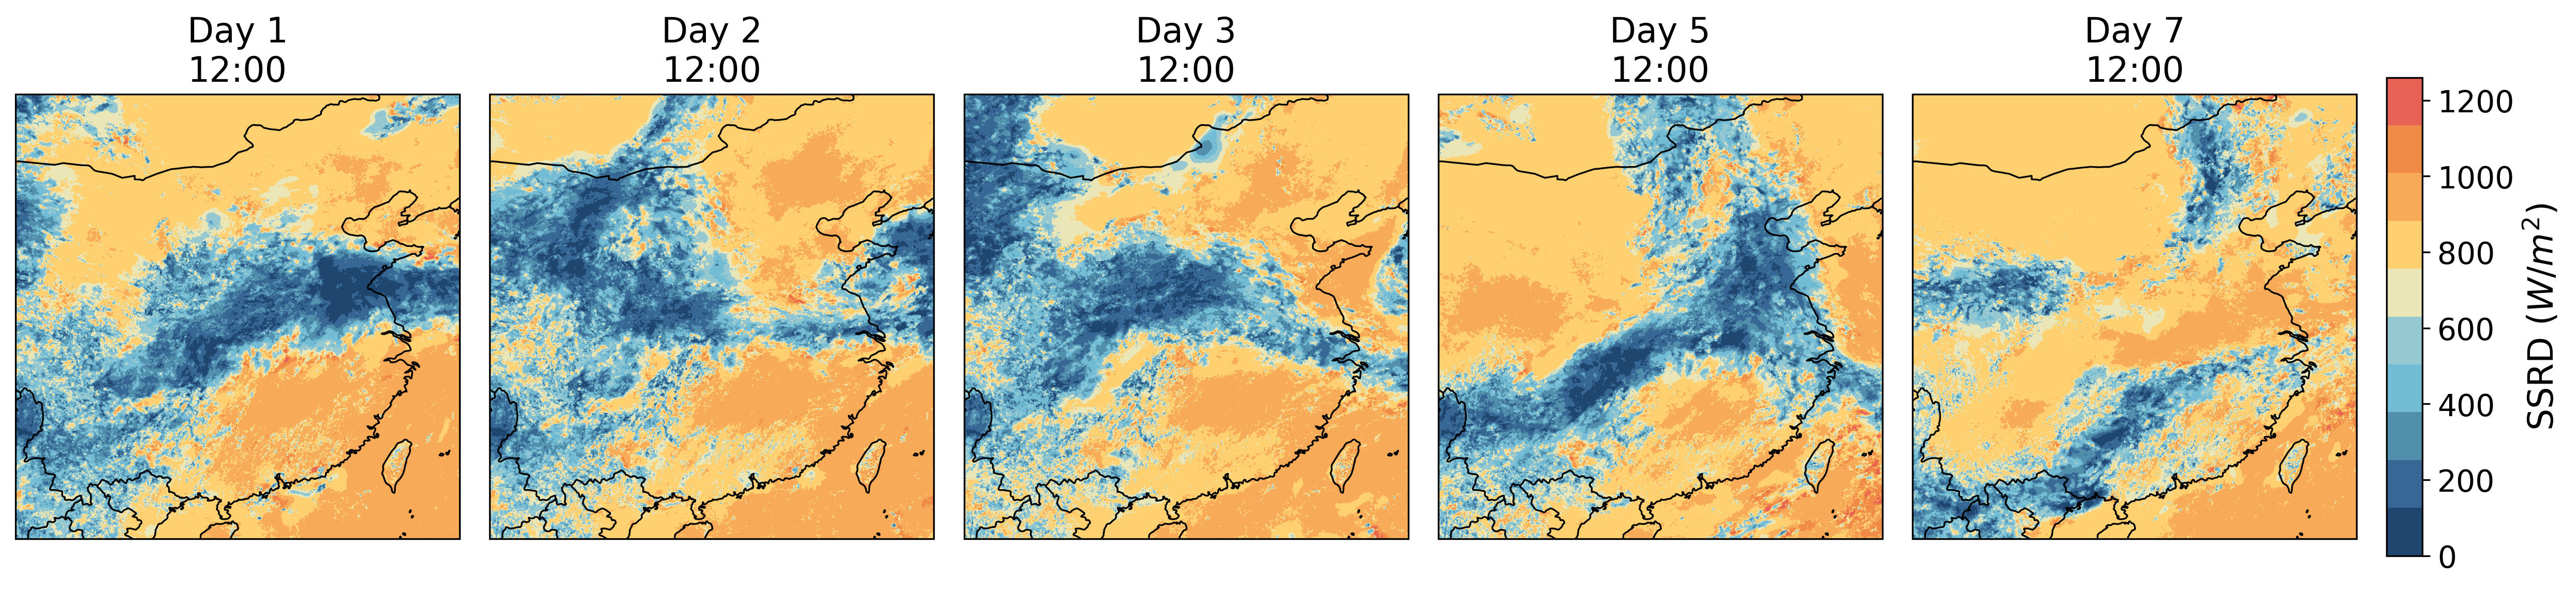

Plotting complete


In [5]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import datetime
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import pandas as pd

color_list = ['#1e466e', '#376795', '#528fad', '#72bcd5', '#96c8d2', '#ebe6b7', '#ffd06f', '#f7aa58', '#ef8a47', '#e76254']
custom_cmap = ListedColormap(color_list)

pred_nc_path = './outputs/solar.nc'

lead_time_index = [54, 198, 342, 630, 918]
# Load prediction
with xr.open_dataset(pred_nc_path) as ds:
    stacked_daily_pred = ds['ssrd'].isel(time=0, lead_time=lead_time_index).values
    lons = ds['lon']
    lats = ds['lat']

# output_dir = "./output"
# os.makedirs(output_dir, exist_ok=True)


vmin_ssrd = stacked_daily_pred.min()
vmax_ssrd = stacked_daily_pred.max()

norm_ssrd = mpl.colors.Normalize(vmin=vmin_ssrd, vmax=vmax_ssrd)

# --- Plotting Configuration ---
n_col = 6
fig = plt.figure(figsize=(20, 4), dpi=300)

# Adjust width ratios for 7 columns: cbar1, pred1, gt1, pred2, gt2, error, cbar2
gs = GridSpec(1, n_col, figure=fig, width_ratios=[1, 1, 1, 1, 1, 0.08],
              height_ratios=[1], hspace=0.08, wspace=0.08)

current_day = [1, 2, 3, 5, 7]
# --- Plotting loop ---
for i_col in range(n_col):

    if i_col < n_col - 1:
        ax = fig.add_subplot(gs[0, i_col], projection=ccrs.PlateCarree())

        data = stacked_daily_pred[i_col]
        contour = ax.contourf(lons, lats, data, levels=100, cmap=custom_cmap, transform=ccrs.PlateCarree(), norm=norm_ssrd)
        
        ax.set_title(f"Day {current_day[i_col]}\n12:00", fontsize=16)
        # Common plot features
        ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

    else:

        cbar_ax = fig.add_subplot(gs[:, i_col])
        sm_ssrd = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm_ssrd)
        cbar = fig.colorbar(sm_ssrd, cax=cbar_ax, orientation='vertical')
        cbar.set_label('SSRD ($W/m^2$)', fontsize=16)
        cbar_ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
print("Plotting complete")